<h>1- Forecasting of partition datasets in route ../dataset/partitions
Target: averaged_queue_time_per_job
Book source: Timeseries analysis with Python Cookbook (Atwan)</h>

In [202]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

Analysis of medium partition
Based on techniques from book Python Data Science Essentials and Timeseries forecasting in Python

In [3]:
medium_df = pd.read_csv("../dataset/partitions/medium_partition.csv", index_col=False)
medium_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date,25716.0,1.679344e+09,2.710670e+06,1.674810e+09,1.676872e+09,1.679630e+09,1.681584e+09,1.683887e+09
availability,25708.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
avg_alloc_mem,25708.0,1.098207e+05,2.346865e+04,0.000000e+00,9.298000e+04,1.077664e+05,1.237000e+05,2.400000e+05
avg_allocated_cpus_per_job,25709.0,7.864055e+02,2.500667e+02,-1.000000e+00,6.256783e+02,7.642718e+02,8.918710e+02,2.880000e+03
avg_allocated_nodes_per_job,25709.0,3.071354e+00,9.788056e-01,-1.000000e+00,2.444056e+00,2.985437e+00,3.483871e+00,1.125000e+01
node_total,23796.0,1.334600e+03,6.302740e+01,3.000000e+00,1.324000e+03,1.361000e+03,1.368000e+03,1.379000e+03
avg_cpus_load_lower,25708.0,7.681426e+01,1.689330e+02,0.000000e+00,3.636600e+01,5.250792e+01,6.806125e+01,1.664107e+03
nodes,23796.0,1.334600e+03,6.302740e+01,3.000000e+00,1.324000e+03,1.361000e+03,1.368000e+03,1.379000e+03
avg_cpus_load_upper,25708.0,1.675540e+02,2.422030e+02,2.000000e-02,9.505513e+01,1.106183e+02,1.301676e+02,3.910001e+03
avg_execution_time_per_job,25709.0,5.340006e+04,1.340223e+04,-1.000000e+00,4.452556e+04,5.238777e+04,6.160673e+04,1.862302e+05


In [4]:
# 1- detect columns to drop based on occurrence of null values (>1%)
null_values = medium_df.isnull().sum() * 100 / len(medium_df) # values gives the % of null values for each feature
columns_to_drop= null_values > 1.0
columns_to_drop = medium_df.loc[:, columns_to_drop].columns
# 1- Remove features with significant number of null values
medium_df.drop(columns_to_drop, axis=1, inplace=True)
# Remove rows with null values
medium_df.dropna(inplace=True)

In [5]:
# 1- convert date to time index
medium_df['date'] = pd.to_datetime(medium_df['date'].astype(np.int64), unit='s') 
medium_df.set_index('date', inplace=True)
# 2- remove features with no variance
filter = medium_df.std() == 0
features_to_drop = medium_df.columns[filter]
medium_df.drop(features_to_drop, axis=1, inplace=True)
medium_df.describe().transpose()  
# Sort time index
medium_df.sort_index(inplace=True)

Our target is to forecast the avg_queue_time_per_job based on other features in dataset

In [6]:
a_day_period = 12*24
a_week_period = 7 * a_day_period
full_dataset_len = len(medium_df)

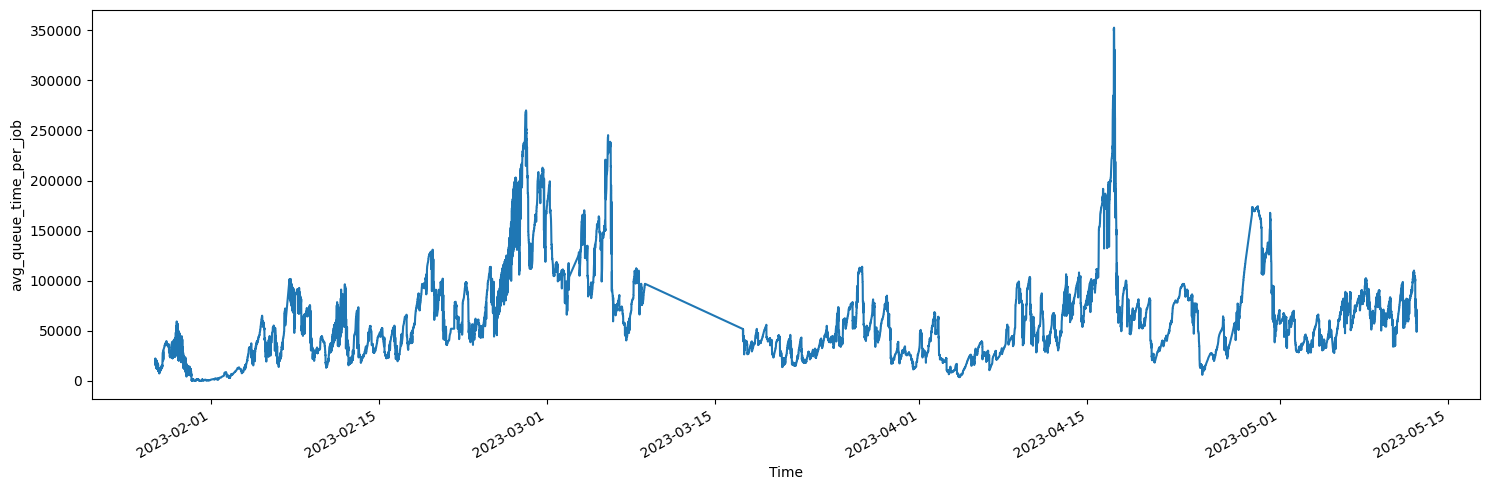

In [18]:
def plot_df_feature(df, feature_name, x_initial=0, x_final=None):
    if x_final is None:
        x_final = len(df)
    y = df[feature_name][x_initial:x_final]
    x = df.index[x_initial:x_final]
    fig, ax = plt.subplots()
    ax.set_xlabel("Time")
    ax.set_ylabel(feature_name)
    fig.set_size_inches(15, 5)
    ax.plot(x, y)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

plot_df_feature(medium_df, "avg_queue_time_per_job", x_initial=0, x_final=full_dataset_len)

Metrics can be plot directly usign pandas.
To see only few metrics, select them with a filter
Using logy=True is y scale is quite different for features
Matplotlib style set. See styles at: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

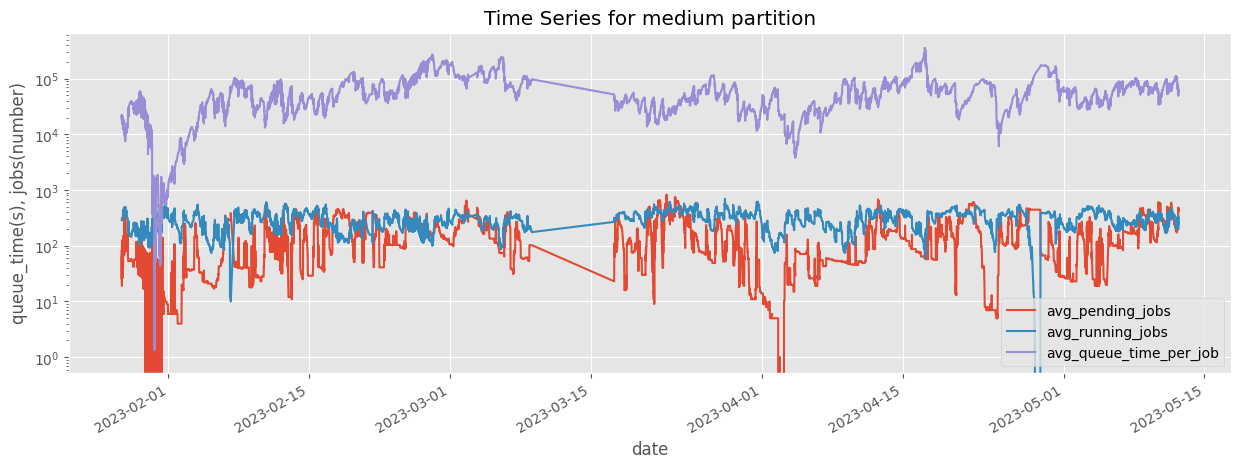

In [109]:
features_to_plot =["avg_pending_jobs", "avg_running_jobs", "avg_queue_time_per_job"]
plt.style.use("ggplot")
plot = medium_df[features_to_plot].plot(logy=True, figsize=(15, 5), title="Time Series for medium partition", ylabel="queue_time(s), jobs(number)")
plot.get_figure().savefig("fig1.png")

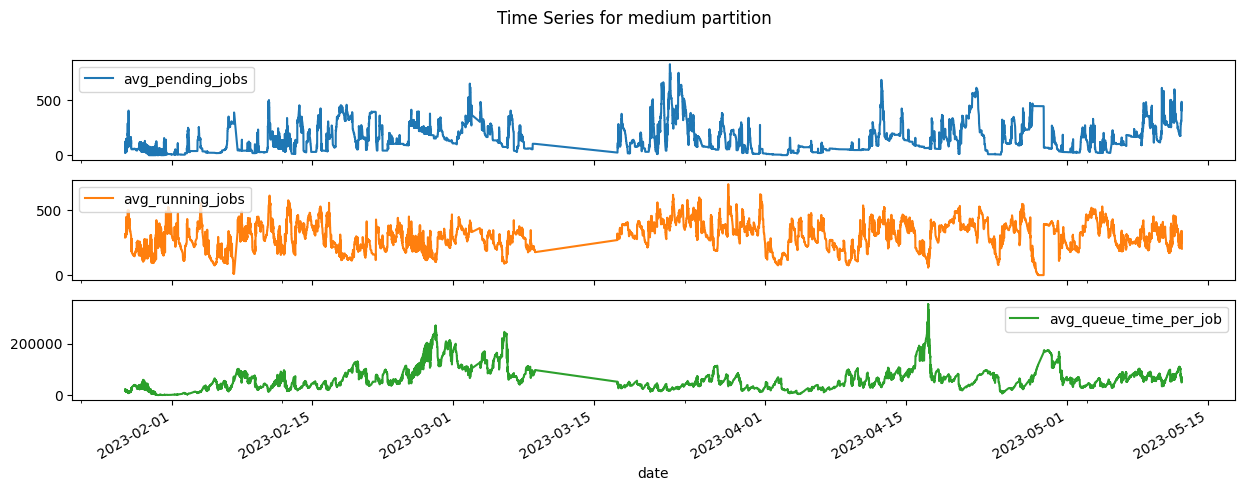

In [110]:
plt.style.use("default")
plots = medium_df[features_to_plot].plot(figsize=(15, 5), title="Time Series for medium partition", subplots=True)


Plotting time series data with interactive visualizations using hvPlot

In [112]:
import hvplot.pandas
import hvplot as hv

In [132]:
medium_df['avg_queue_time_per_job'].hvplot(subplots=True, width=1000)

:Curve   [date]   (avg_queue_time_per_job)

<h>Time series decomposition (trend, seasonality, residuals): 𝑦𝑡 = 𝑇𝑡 + 𝑆𝑡 + 𝑅𝑡</h>

Using seasonal_decompose.
This time series has neither trend nor seasonality, so the results are wrong

In [121]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

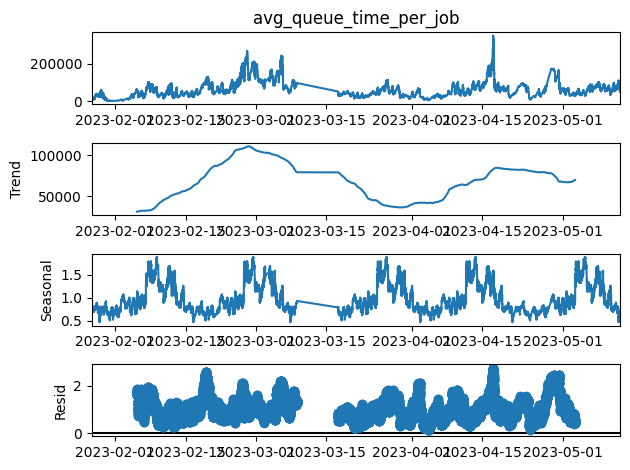

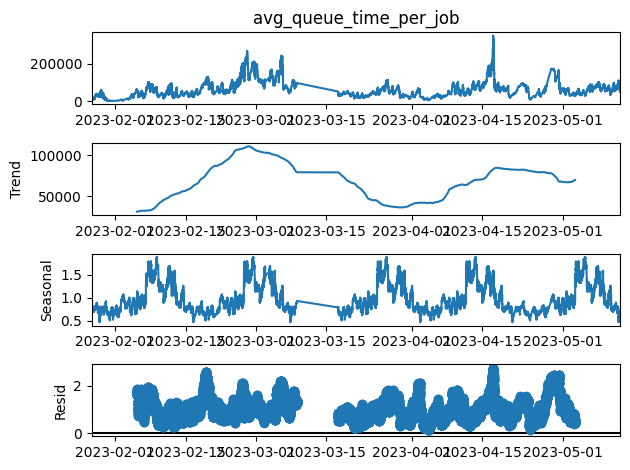

In [188]:
#df = medium_df['avg_queue_time_per_job'][11000:]
df = medium_df['avg_queue_time_per_job']
#df.fillna(method="pad", inplace=True)
a_day_period = 12*24 # 5min sampling
a_week_period = 7 * a_day_period
df_decomposed = seasonal_decompose(df, model='multiplicative', period=a_week_period)
df_decomposed.plot()

Using STL decompose

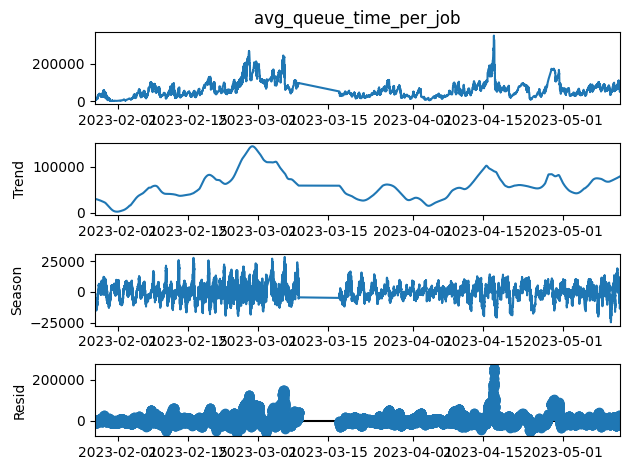

In [190]:
df_stl = STL(df, seasonal=13, robust=True, period=a_day_period).fit()
df_stl.plot(); plt.show()

Hodrick-Prescott filter is a smoothing filter that can be used to separate short-term
fluctuations (cyclic variations) from long-term trends

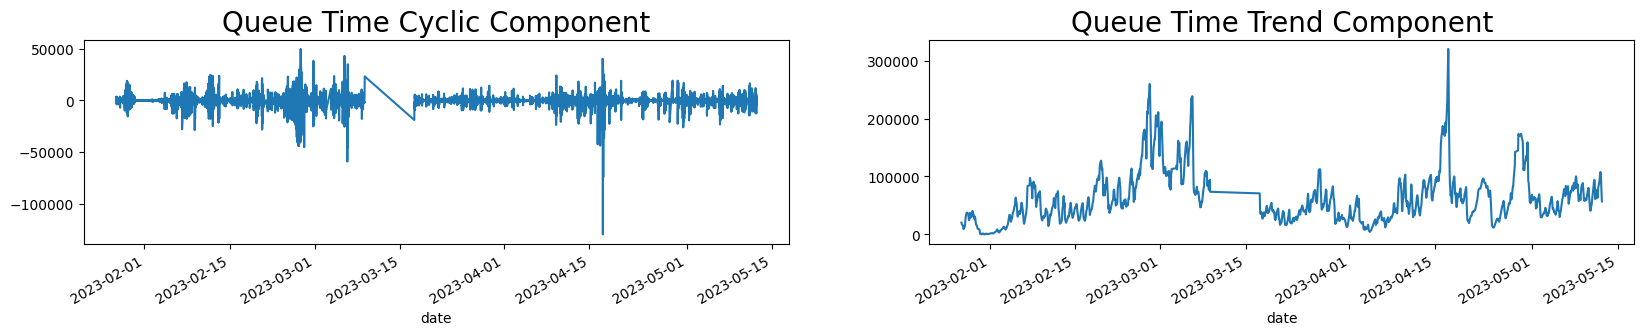

In [193]:
from statsmodels.tsa.filters.hp_filter import hpfilter
plt.rcParams["figure.figsize"] = (20,3)
df_cyclic, df_trend = hpfilter(df)
fig, ax = plt.subplots(1,2)
df_cyclic.plot(ax=ax[0], title='Queue Time Cyclic Component')
df_trend.plot(ax=ax[1], title='Queue Time Trend Component')
ax[0].title.set_size(20); ax[1].title.set_size(20)

Below decomposition techniques cannot determine the seasonality periodicity, as the time series lacks of such periodicity, as concluded by below TFF analysis

Analyse seasonality with Fast Fourier Transform (FFT)
No seasonality is detected

2023-05-22 16:08:52.136449: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 16:08:52.235975: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 16:08:52.237958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 16:08:53.711418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


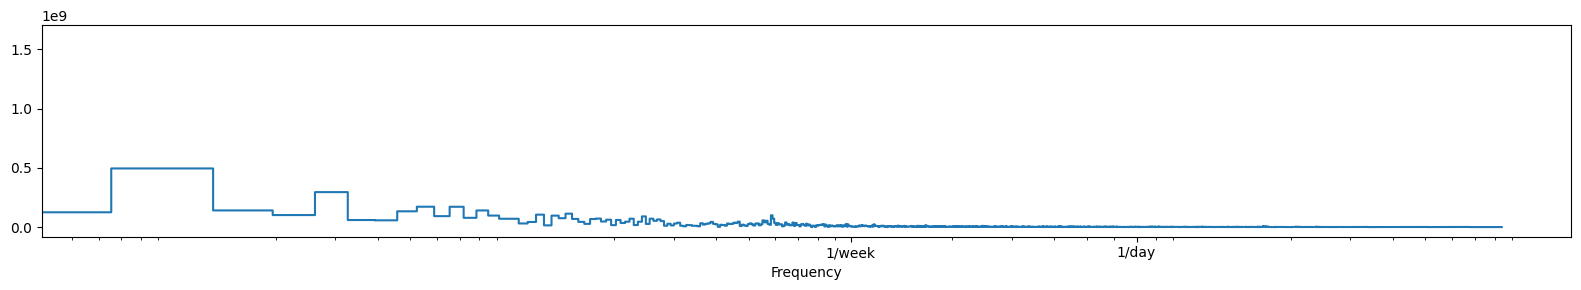

In [8]:
import tensorflow as tf
fft = tf.signal.rfft(medium_df['avg_queue_time_per_job'])

f_per_dataset = np.arange(0, len(fft))
n_sample_h = len(medium_df['avg_queue_time_per_job'])

hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week
f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()


<h>Time series stationarity</h>

In [197]:
from statsmodels.tsa.stattools import adfuller, kpss
avg_queue_time_df = medium_df['avg_queue_time_per_job']

In [196]:
def print_results(output, test='adf'):
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
    output_dict = {
        'Test Statistic': test_score,
        'p-value': pval,
        'Numbers of lags': lags,
        'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
    return pd.Series(output_dict, name=test)

Augmented Dickey-Fuller (ADF)

In [198]:
adf_output = adfuller(avg_queue_time_df)

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [199]:
kpss_output = kpss(avg_queue_time_df)

/home/yosu/miniconda3/envs/permedcoe_forecast/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [201]:
#Not concluding techniques about time series stationarity
pd.concat(
    [
        print_results(adf_output, 'adf'),
        print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Test Statistic,-5.556568,1.466135
p-value,0.000002,0.01
Numbers of lags,46,95
decision,Stationary,Non-Stationary
Critical Value (1%),-3.430605,0.739
Critical Value (5%),-2.861653,0.463
Critical Value (10%),-2.56683,0.347
Critical Value (2.5%),NaN,0.574


Check book reference (Atwan: Time series analysis with python cookbook, chapter 9) for techniques to make stationary a time series

In [9]:
def determine_dropped_colums(df: pd.core.frame.DataFrame, df_selected: np.ndarray):
    original_columns = df.columns
    dropped_columns = []
    index = -1
    for value in df.iloc[0]:
        index += 1
        if value not in df_selected[0]:
            dropped_columns.append(original_columns[index])
    return dropped_columns

Checking normality (Gaussian distribution)

In [206]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

In [207]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > p_level else 'Not Normal'

Run several tests to check the normality of queue_time series.
Shapiro test is enough reliable, So there is no need to test only with this method
All tests confirm avg_queue_time is not normal
Same result (not normal) for other features in DF, despite their histograms look normal

In [208]:
normal_args = (np.mean(avg_queue_time_df),np.std(avg_queue_time_df))
print(is_normal(shapiro(avg_queue_time_df)))
print(is_normal(normaltest(avg_queue_time_df)))
print(is_normal(normal_ad(avg_queue_time_df)))
print(is_normal(kstest_normal(avg_queue_time_df)))
print(is_normal(kstest(avg_queue_time_df, cdf='norm',
    args=(np.mean(avg_queue_time_df), np.std(avg_queue_time_df)))))

Not Normal
Not Normal
Not Normal
Not Normal
Not Normal


In [216]:
avg_execution_time_per_job_df = medium_df['avg_execution_time_per_job']
normal_args = (np.mean(avg_execution_time_per_job_df),np.std(avg_execution_time_per_job_df))
print(is_normal(shapiro(avg_execution_time_per_job_df)))
print(is_normal(normaltest(avg_execution_time_per_job_df)))
print(is_normal(normal_ad(avg_execution_time_per_job_df)))
print(is_normal(kstest_normal(avg_execution_time_per_job_df)))
print(is_normal(kstest(avg_execution_time_per_job_df, cdf='norm',
    args=(np.mean(avg_execution_time_per_job_df), np.std(avg_execution_time_per_job_df)))))

Not Normal
Not Normal
Not Normal
Not Normal
Not Normal


<Axes: >

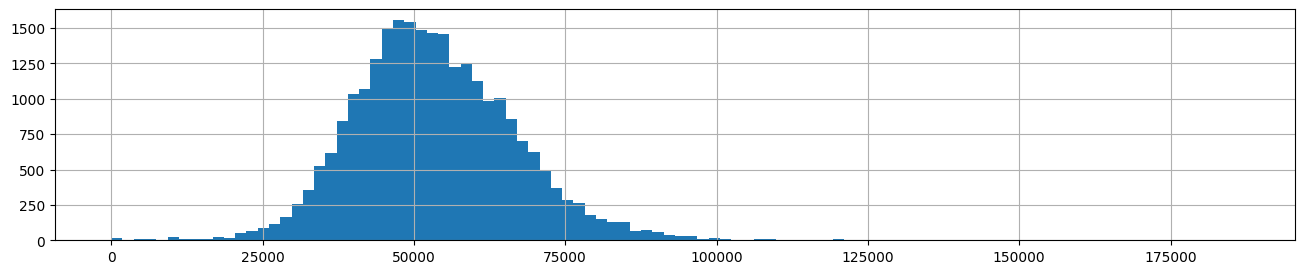

In [217]:
avg_execution_time_per_job_df.hist(bins=100)

Checking Homoskedasticity (variance is stable over time) vs heteroskedasticity
testing for the stability of the variance against the model's residuals

In [227]:
from statsmodels.stats.api import (het_breuschpagan, het_goldfeldquandt, het_white)
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        test(model.resid,
            sm.add_constant(
            model.fittedvalues)
    ))
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"

In [221]:
from statsmodels.tsa.api import AutoReg
model = AutoReg(avg_queue_time_df.dropna(), lags=1).fit()

Test determines queue_time series is Heteroskedastic (variance changes over time)

In [229]:
het_test(model, test=het_breuschpagan)

'Heteroskedastic'

Transforming into normal, homoskedastic time series: Box-Cox transformation
Applying Box-Cox transform

In [230]:
from scipy.stats import boxcox

In [231]:
xt, lmbda = boxcox(avg_queue_time_df)
xts = pd.Series(xt, index=avg_queue_time_df.index)

Histogram for boxcox transformed df looks normal, BUT

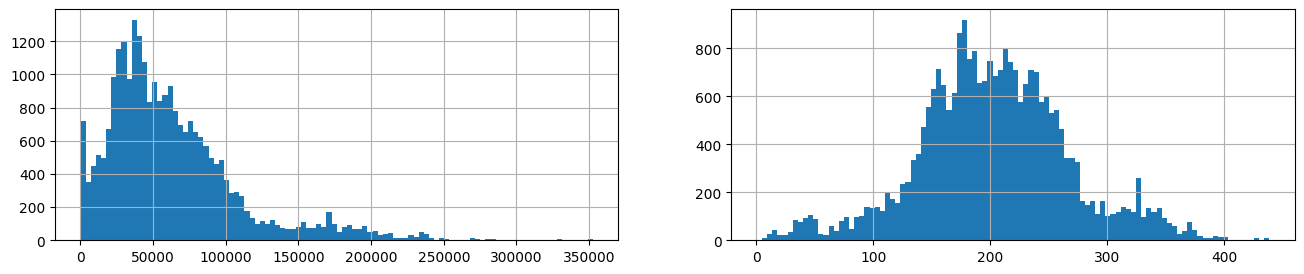

In [234]:
fig, ax = plt.subplots(1, 2)
avg_queue_time_df.hist(ax=ax[0], bins=100)
xts.hist(ax=ax[1], bins=100)
plt.show()

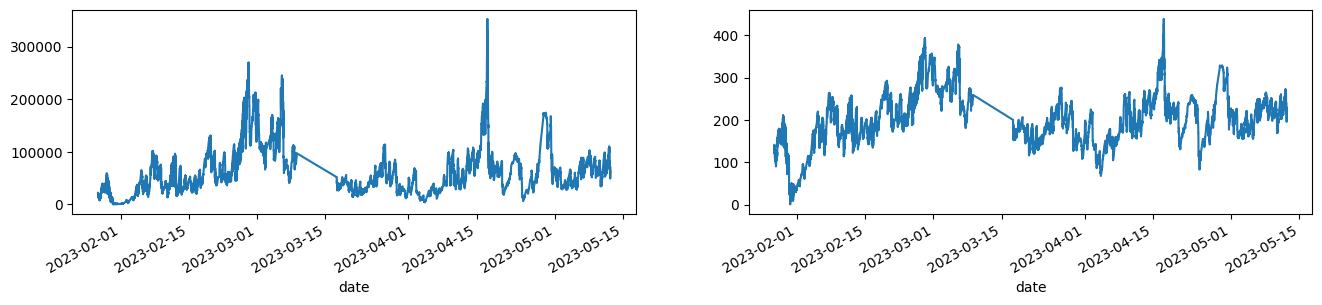

In [235]:
fig, ax = plt.subplots(1, 2)
avg_queue_time_df.plot(ax=ax[0])
xts.plot(ax=ax[1])
plt.show()

However, in this case the boxcox transformation fails on creating a normally distributed time series, as detected by the shapiro test

In [242]:
print(is_normal(shapiro(xts)))

Not Normal


Analysis of residuasl (actual values - predictions) of a AutoRegression model
Results show residuals are not normal.

       Test of No Serial Correlation       
       Lag  Ljung-Box LB P-value         DF
-------------------------------------------
         1    933.449      0.000          1
         2    934.030      0.000          2
         3   1690.464      0.000          3
         4   1690.902      0.000          4
         5   1726.381      0.000          5
         6   1726.625      0.000          6
         7   1975.481      0.000          7
         8   1975.506      0.000          8
         9   2004.643      0.000          9


             Test of Normality              
Jarque-Bera    P-value   Skewness   Kurtosis
--------------------------------------------
1632491.271      0.000     -2.903     41.606


    Test of Conditional Homoskedasticity   
       Lag    ARCH-LM    P-value         DF
-------------------------------------------
         1      8.673      0.003          1
         2   1385.570      0.000          2
         3   1390.513      0.000          3
         4   1699.145   

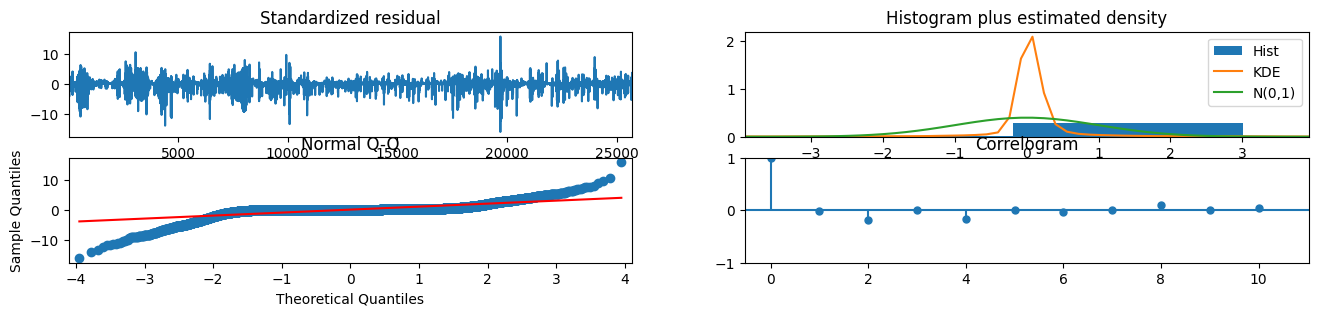

In [243]:
model_bx = AutoReg(xts, lags=1, trend='n').fit()
print(model_bx.diagnostic_summary()), model_bx.plot_diagnostics(); plt.show()

Autocorrelation (Ljung-Box test)
No clear results, p_value = 0 < 0.05, therefore null-hipotesis cannot be rejected, so there is autorrelation for each lag in range [1, 10]

In [245]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(avg_queue_time_df, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,25467.281134,0.0
2,50695.360081,0.0
3,75769.032222,0.0
4,100690.912951,0.0
5,125548.263595,0.0
6,150342.424746,0.0
7,175117.010263,0.0
8,199872.481824,0.0
9,224597.238072,0.0
10,249289.582313,0.0


Feature selection: drop features with low variance

In [10]:
from sklearn.feature_selection import VarianceThreshold
medium_df_selected = VarianceThreshold(threshold=1.0).fit_transform(medium_df)
dropped_columns = determine_dropped_colums(medium_df, medium_df_selected)
old_columns = medium_df.columns
new_columns = old_columns.drop(dropped_columns)
medium_df_selected = pd.DataFrame(medium_df_selected, columns=new_columns, index=medium_df.index)
medium_df_selected.describe().transpose()
# These columns should have been removed from dataset: avg_allocated_nodes_per_job, avg_maximum_allocated_nodes_per_job, avg_minimum_requested_nodes_per_job

,count,mean,std,min,25%,50%,75%,max
avg_alloc_mem,25708.0,109820.712528,23468.654668,0.000000,92980.000000,107766.400000,123700.000000,240000.000000
avg_allocated_cpus_per_job,25708.0,786.394447,250.065269,-1.000000,625.678322,764.271845,891.785421,2880.000000
avg_cpus_load_lower,25708.0,76.814262,168.933019,0.000000,36.366000,52.507917,68.061250,1664.106667
avg_cpus_load_upper,25708.0,167.554043,242.202998,0.020000,95.055125,110.618333,130.167625,3910.001250
avg_execution_time_per_job,25708.0,53398.963446,13401.336650,-1.000000,44523.394166,52387.769912,61606.734940,186230.188144
avg_free_mem_lower,25708.0,187403.889372,18781.242197,7658.000000,179463.487500,190560.714286,199657.000000,246061.000000
avg_free_mem_upper,25708.0,234923.756764,7533.645046,160283.750000,230433.888889,236088.500000,240407.025000,249717.000000
avg_maximum_allocated_cpus_per_job,25708.0,671.881426,184.698289,203.279597,539.899576,655.960591,774.701571,1529.901679
avg_minimum_requested_cpus_per_job,25708.0,108.676288,16.093355,40.965278,100.820494,113.756863,120.081916,149.077244
avg_minimum_requested_memory_per_job,25708.0,214627.652140,33484.517983,60568.814480,202547.222378,231458.812227,236067.187328,240000.000000


Split dataset into train, validation and test

In [11]:
X_columns = medium_df_selected.columns.drop("avg_queue_time_per_job")
X = medium_df_selected[X_columns]
y = medium_df_selected["avg_queue_time_per_job"]

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [13]:
n = len(medium_df_selected)
train_df = medium_df_selected[0:int(0.7*n)] # 70% 
val_df = medium_df_selected[int(0.7*n):int(0.9*n)] # 20%
test_df = medium_df_selected[int(0.9*n):] # 10%

Scale dataset to range [0, 1] for better ML model performance and lower training time

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df)
columns = train_df.columns
index = train_df.index
train_df = pd.DataFrame(scaler.transform(train_df[train_df.columns]), columns=train_df.columns, index=train_df.index)
val_df = pd.DataFrame(scaler.transform(val_df[val_df.columns]), columns=val_df.columns, index=val_df.index)
test_df = pd.DataFrame(scaler.transform(test_df[test_df.columns]), columns=test_df.columns, index=test_df.index)

Handling missing data (chapter 7)
TODO 

Outlier detection (chapter 8) with statistical techniques

In [66]:
def plot_outliers(outliers, data, label, feature=None, method='KNN',
    halignment = 'right',
    valignment = 'bottom',
    labels=False):
    ax = None
    if feature is None:
        ax = data.plot(alpha=0.6)
    else:
        ax = data[label].plot(alpha=0.6)
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}',
            horizontalalignment=halignment,
            verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
    plt.title(f'{label} - {method}')
    plt.xlabel('date'); plt.ylabel(f'{label}')
    plt.legend([f'{label}','outliers'])
    plt.show()

Resampling data

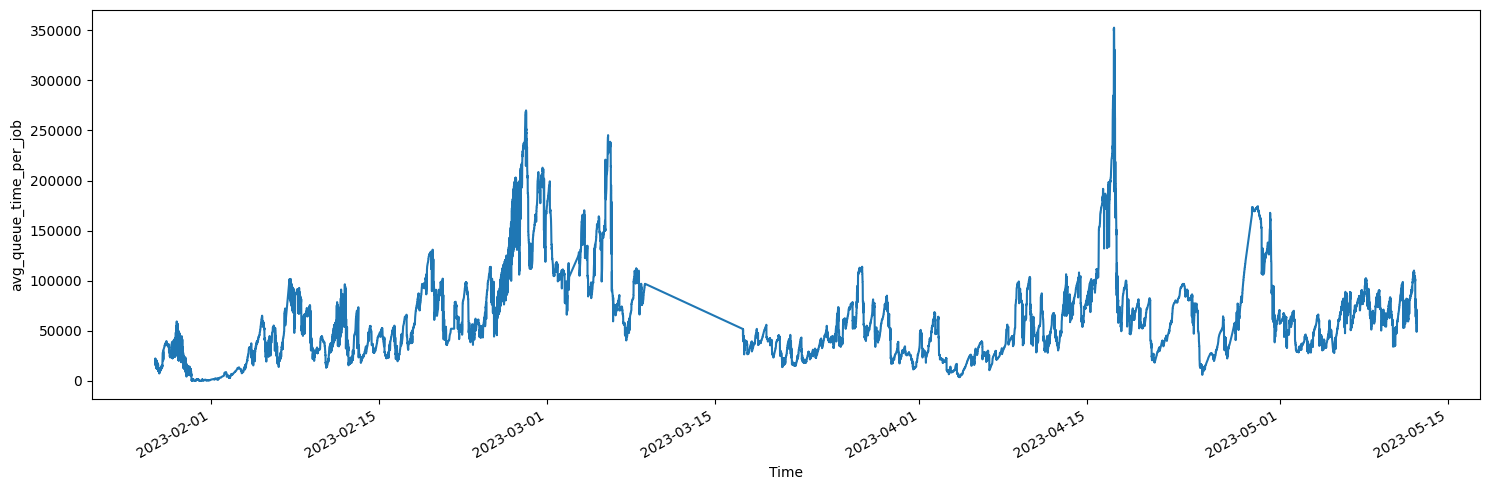

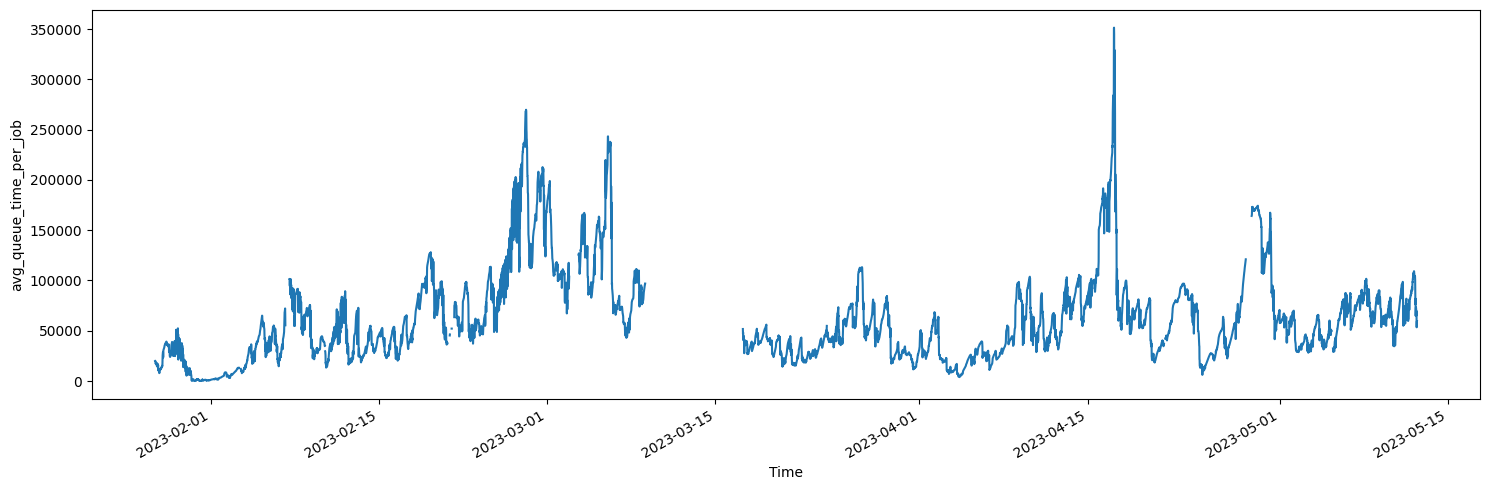

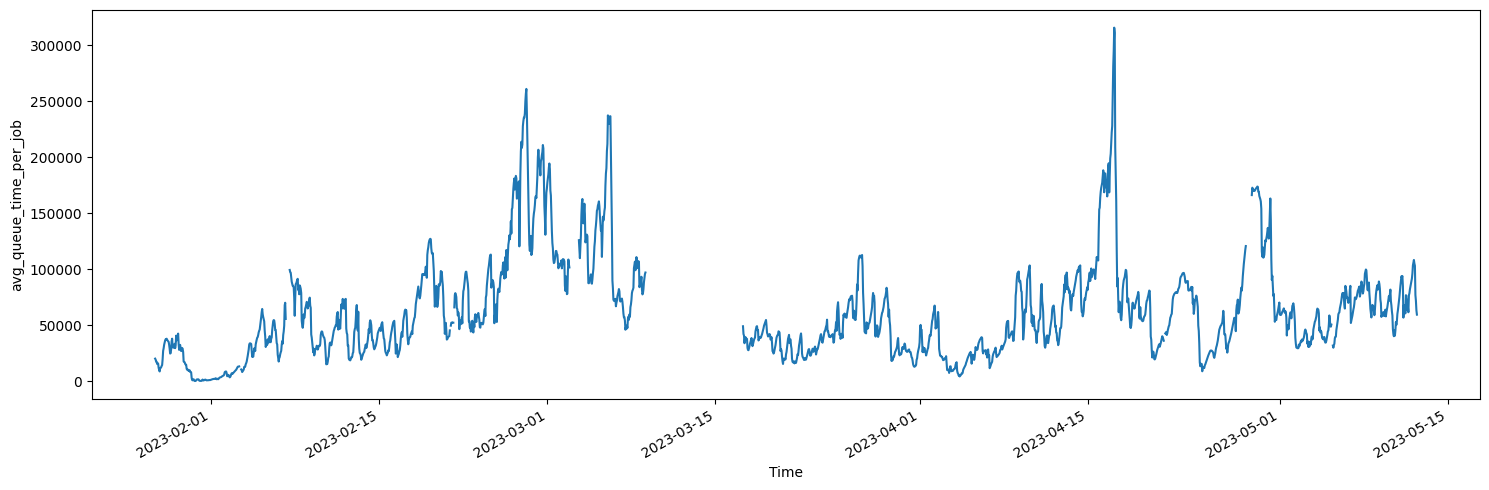

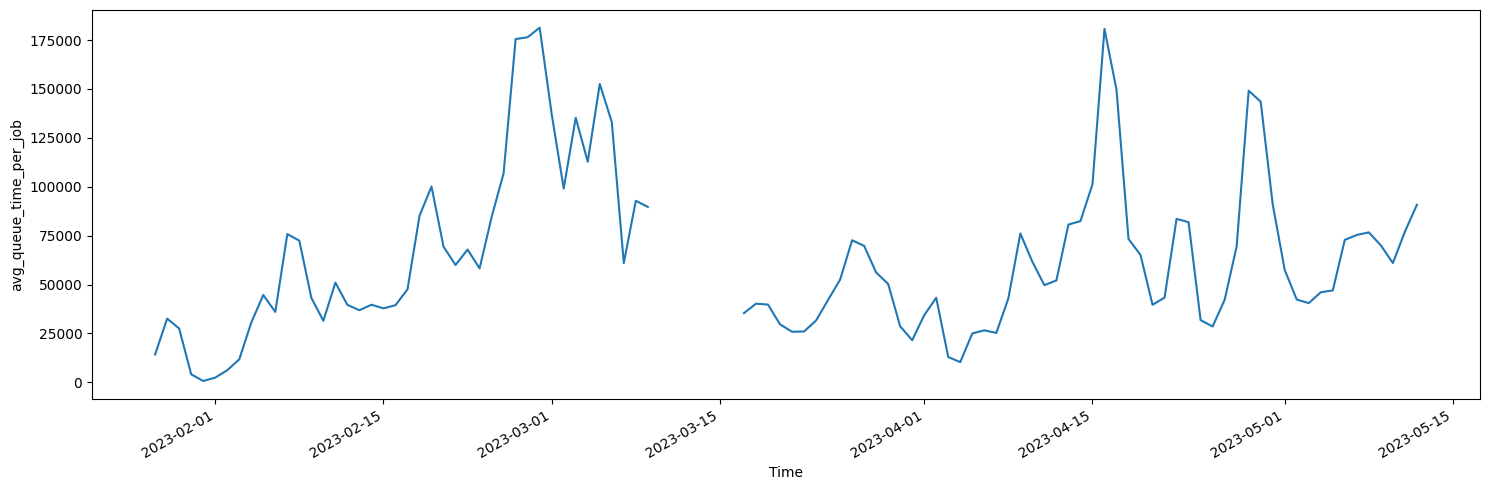

In [23]:
avg_queueu_time_df = medium_df_selected['avg_queue_time_per_job']
plot_df_feature(medium_df_selected, 'avg_queue_time_per_job')
plot_df_feature(medium_df_selected.resample('15T').mean(), 'avg_queue_time_per_job')
plot_df_feature(medium_df_selected.resample('H').mean(), 'avg_queue_time_per_job')
plot_df_feature(medium_df_selected.resample('D').mean(), 'avg_queue_time_per_job')

Detecting outliers with visualization techniques

Using histograms

<Axes: xlabel='avg_queue_time_per_job', ylabel='Count'>

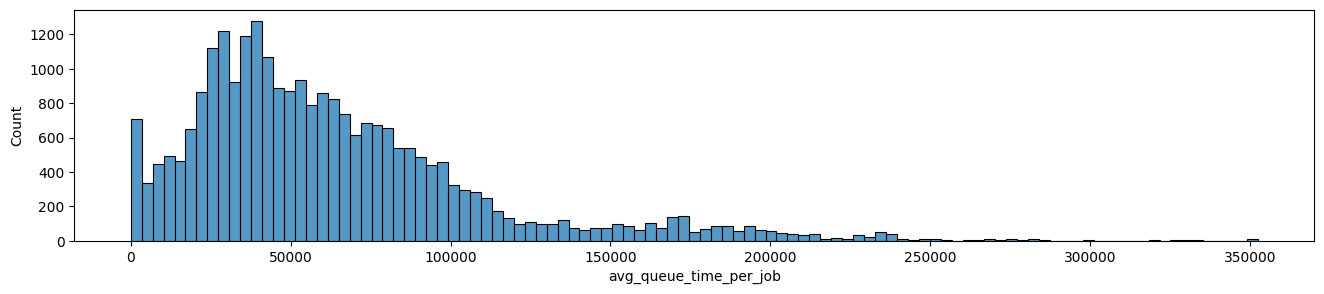

In [26]:
sns.histplot(avg_queueu_time_df)

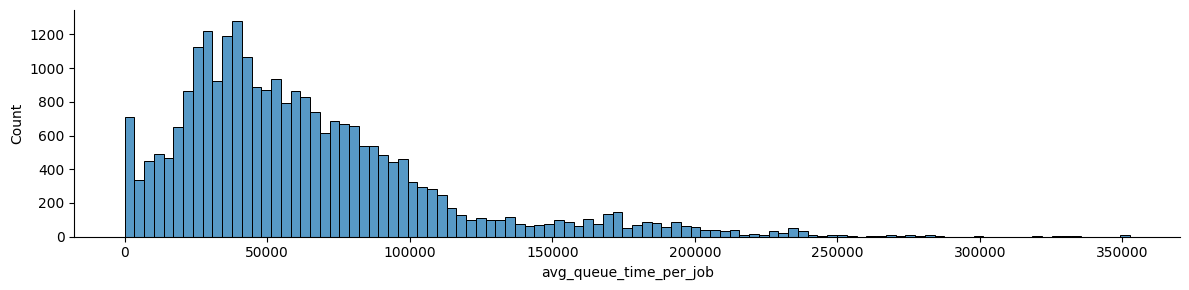

In [27]:
sns.displot(avg_queueu_time_df, kind='hist', height=3, aspect=4)

using boxplot

<Axes: >

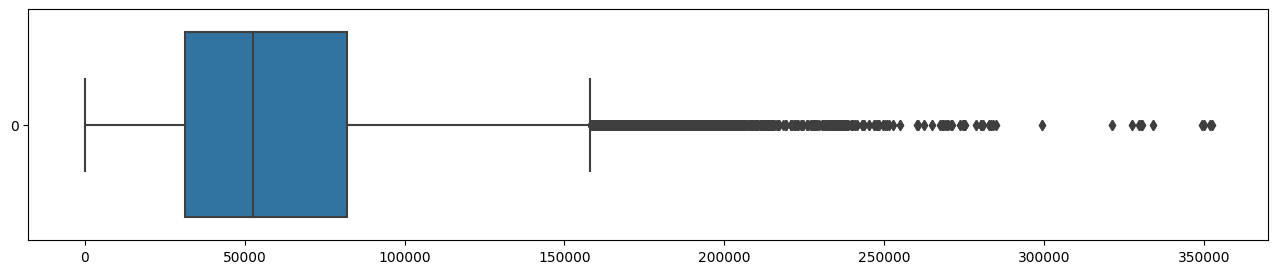

In [33]:
sns.boxplot(avg_queueu_time_df, whis=1.5, orient='h')

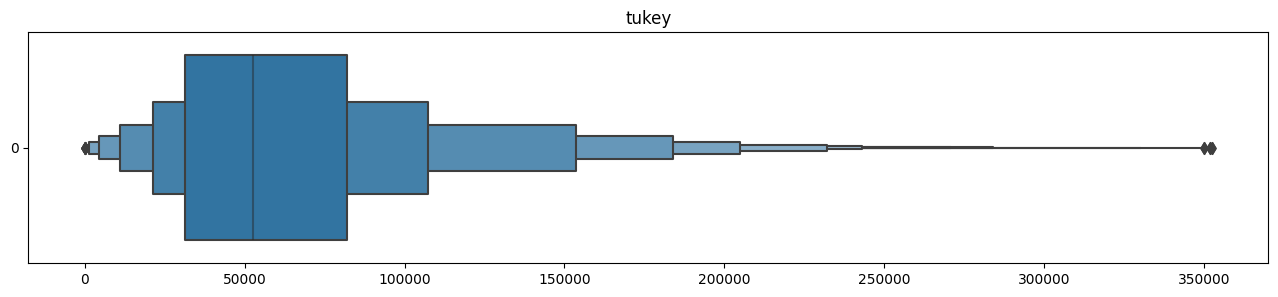

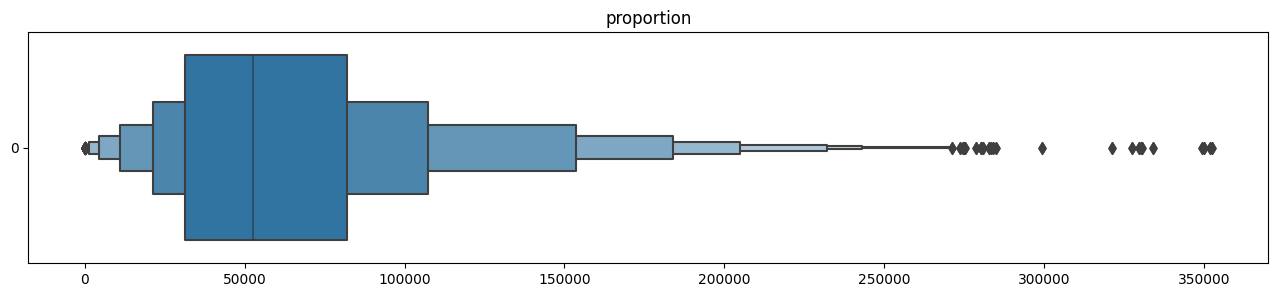

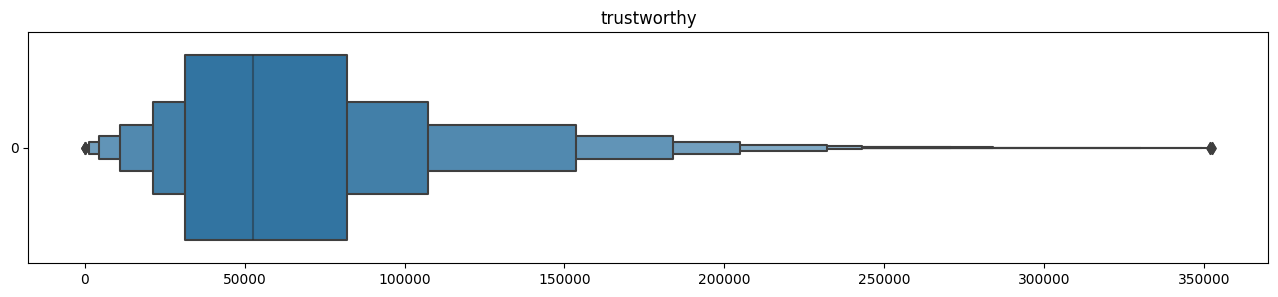

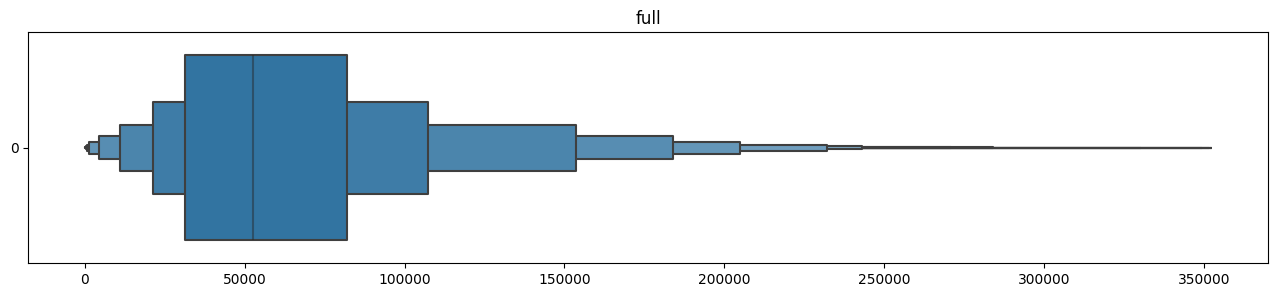

In [37]:
for k in ["tukey", "proportion", "trustworthy", "full"]:
    sns.boxenplot(avg_queueu_time_df, k_depth=k, orient='h')
    plt.title(k)
    plt.show()

<Axes: >

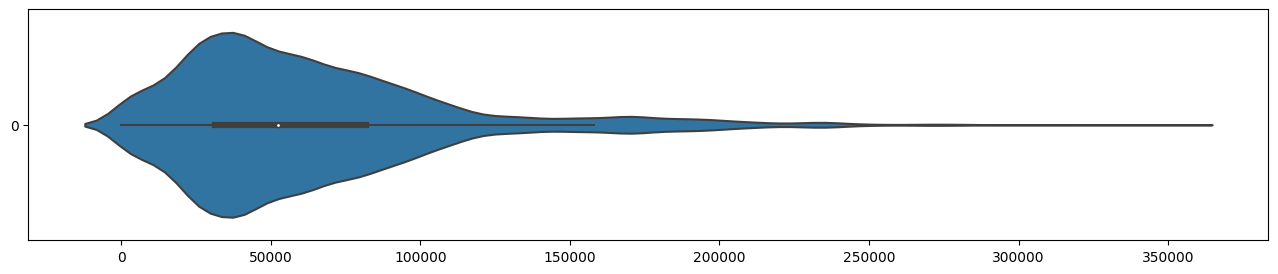

In [39]:
sns.violinplot(avg_queueu_time_df, orient='h')

Lag plot
Scatter plot with t-1 lagged value (5 min for normal sampling). Resampling for hours and days to compare with previous one

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

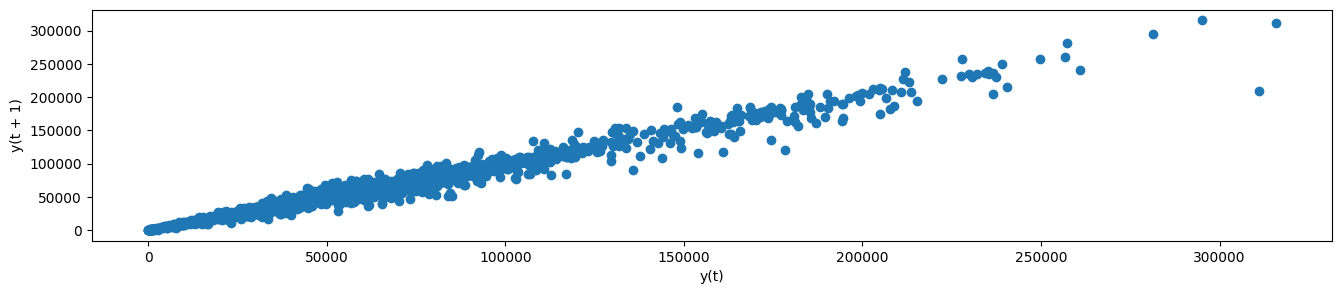

In [48]:
lag_plot(avg_queueu_time_df.resample('1H').mean())

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

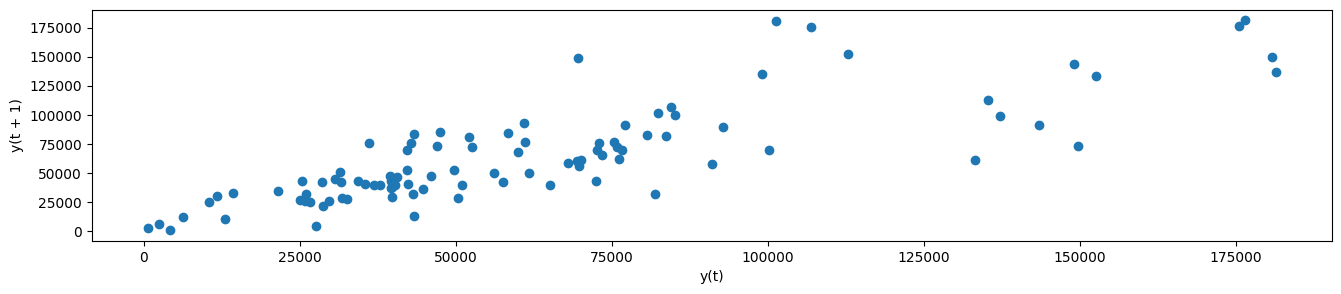

In [49]:
lag_plot(avg_queueu_time_df.resample('1D').mean())

Tukey method for detecting outliers

In [50]:
# Define quantiles
percentiles = [0, .05, .10, .25, .50, .75, .90, .95, 1]
avg_queueu_time_df.describe(percentiles=percentiles)

count     25708.000000
mean      63080.345636
std       46296.386839
min           1.342995
0%            1.342995
5%         8673.947306
10%       17904.495050
25%       31236.781182
50%       52585.930921
75%       82004.160526
90%      117493.979508
95%      166659.805556
100%     352544.642276
max      352544.642276
Name: avg_queue_time_per_job, dtype: float64

In [51]:
#Percentiles with numpy
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 100]
np.percentile(avg_queueu_time_df, percentiles)

array([1.34299517e+00, 8.67394731e+03, 1.79044950e+04, 3.12367812e+04,
       5.25859309e+04, 8.20041605e+04, 1.17493980e+05, 1.66659806e+05,
       3.52544642e+05])

In [69]:
#using Tukey fences, outliers outside inner boundaries (Q1 - 1.5*IQR, Q3 + 1.5 * IQR)
def iqr_outliers(data: pd.core.series.Series, p=1.5):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (p * IQR)
    upper_fence = q3 + (p * IQR)
    return data[(data > upper_fence) | (data < lower_fence)]

In [55]:
type(avg_queueu_time_df)

pandas.core.series.Series

In [70]:
outliers = iqr_outliers(avg_queueu_time_df)
avg_queueu_time_df.shape, outliers.shape
#1495 outliers detected outside Tukey fences

((25708,), (1495,))

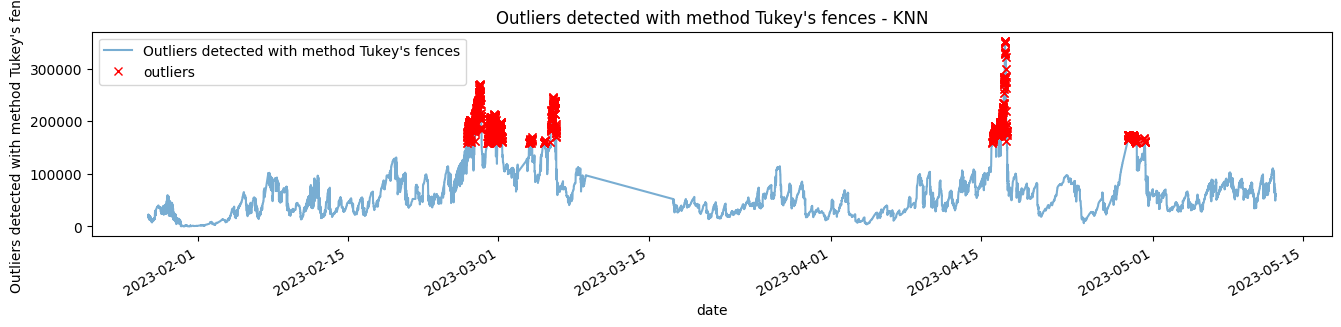

In [67]:
plot_outliers(outliers, avg_queueu_time_df, "Outliers detected with method Tukey's fences")

Detecting outliers with z-score
Based on standardized (scaled) data z = (x - mean) / std
outliers = |data| > 3 * std
Note: Requires data follows a Gaussian distribution, which is not the case for avg_queue_time

In [79]:
def zscore(df:pd.DataFrame, feature, degree=3):
    data = df.copy()
    data['zscore'] = (data - data.mean())/data.std()
    outliers = data[(data['zscore'] <= -degree) |
    (data['zscore'] >= degree)]
    return outliers[feature], data

In [80]:
threshold = 3
outliers, transformed = zscore(avg_queueu_time_df.to_frame(), 'avg_queue_time_per_job', degree= threshold)

array([[<Axes: title={'center': 'avg_queue_time_per_job'}>,
        <Axes: title={'center': 'zscore'}>]], dtype=object)

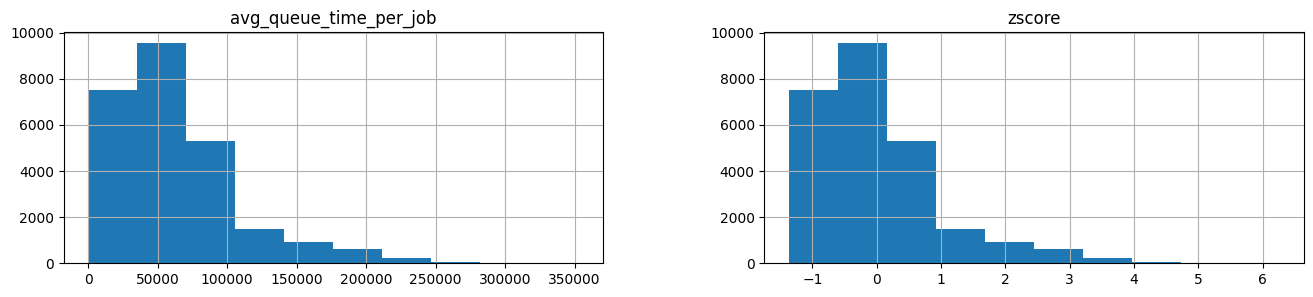

In [81]:
# This method for detecting outliers is not applicable in this case, as the distribution is not gaussian
transformed.hist()

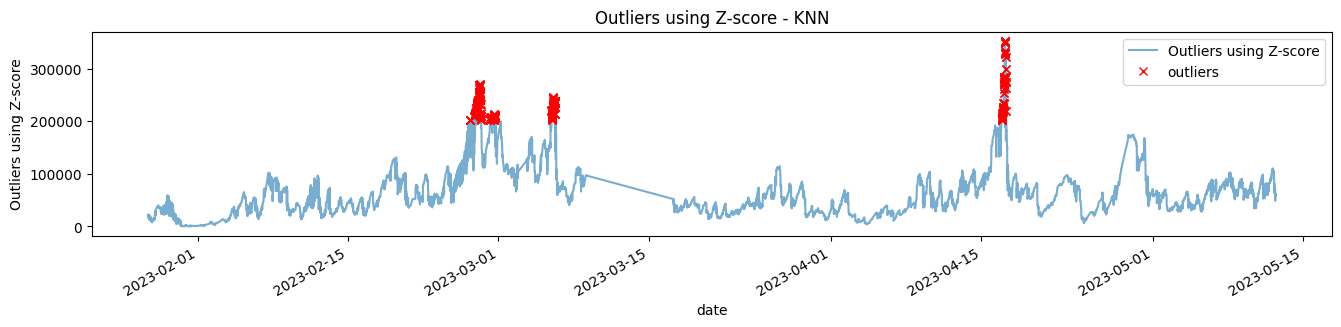

In [82]:
#Plot outliers detected with this method
plot_outliers(outliers, avg_queueu_time_df, "Outliers using Z-score")

In [83]:
def plot_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data,'k^')
    plt.plot([0,n],[d,d],'r--')
    plt.plot([0,n],[-d,-d],'r--')

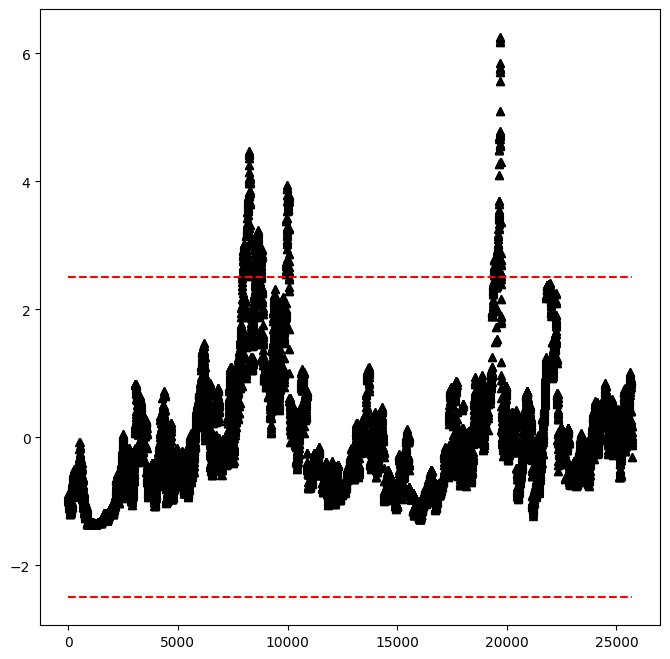

In [84]:
data = transformed['zscore'].values
plot_zscore(data, d=2.5)

Let's check if data is normally distributed
Kolmogorov-Smirnov test

In [85]:
from statsmodels.stats.diagnostic import kstest_normal
def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")

In [86]:
test_normal(avg_queueu_time_df)

Reject null hypothesis. Data is not normal


Another test to check normality and detect outliers
Quantile-Quantile plot (QQ-plot)

Using scipy
Graph shows it is not normal (not straight line)

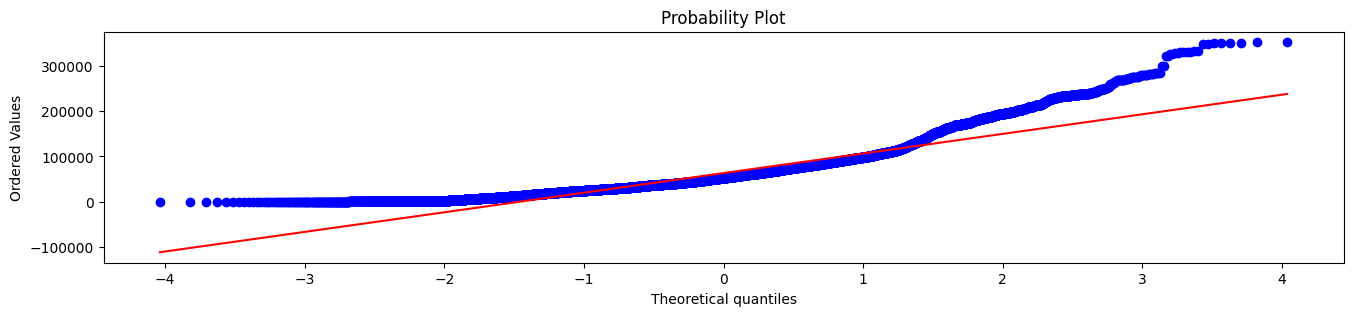

In [97]:
import scipy.stats as stats
res = stats.probplot(avg_queueu_time_df.to_frame().values.reshape(-1), plot=plt)

Using statsmodels

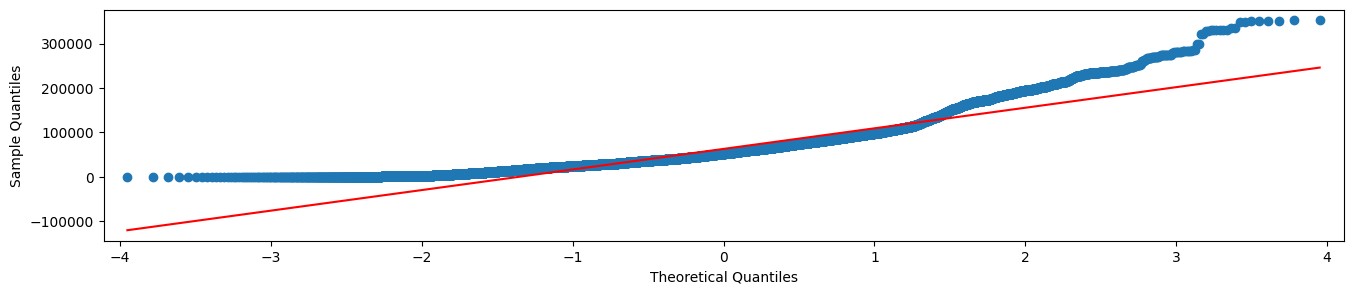

In [98]:
from statsmodels.graphics.gofplots import qqplot
qqplot(avg_queueu_time_df.to_frame().values.reshape(-1), line='s')
plt.show()

Detecting outliers using a modified z-score (robust z-score)
For non-normal datasets 

In [92]:
def modified_zscore(df:pd.DataFrame, feature, degree=3):
    data = df.copy()
    s = stats.norm.ppf(0.75)
    numerator = s*(data - data.median())
    MAD = np.abs(data - data.median()).median()
    data['m_zscore'] = numerator/MAD
    outliers = data[(data['m_zscore'] > degree) | (data['m_zscore'] < -degree)]
    return outliers[feature], data

In [93]:
threshold = 3
outliers, transformed = modified_zscore(avg_queueu_time_df.to_frame(), 'avg_queue_time_per_job', degree= threshold)

array([[<Axes: title={'center': 'avg_queue_time_per_job'}>,
        <Axes: title={'center': 'm_zscore'}>]], dtype=object)

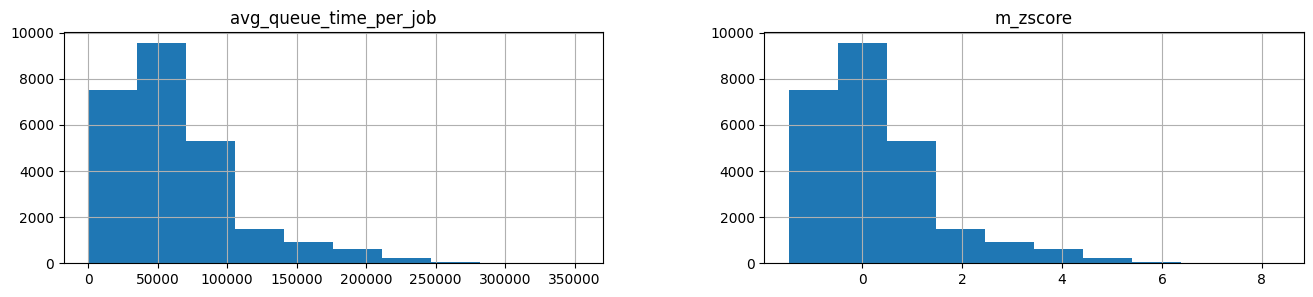

In [94]:
transformed.hist()

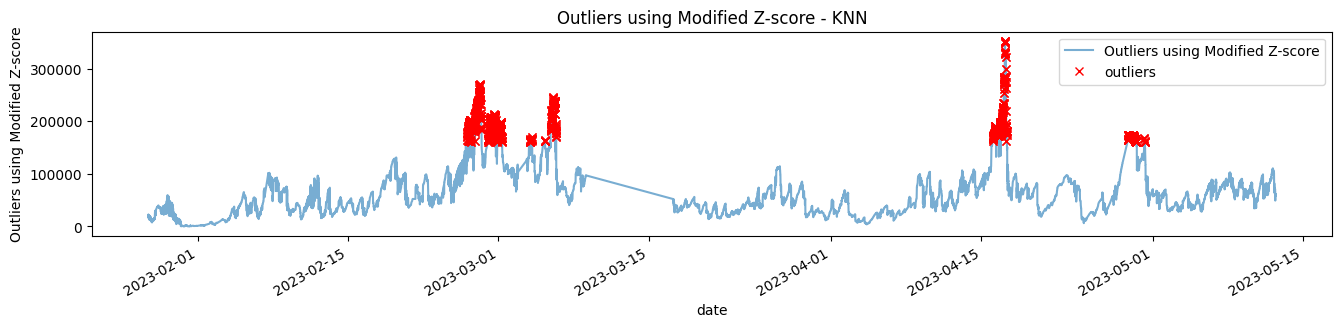

In [95]:
plot_outliers(outliers, avg_queueu_time_df, "Outliers using Modified Z-score")

<h>Forecasting using supervised ML</h>

Prepare dataset with sliding window

In [261]:
def handle_missing_data(df, frequency="5min"):
    return df.resample(frequency).interpolate()

In [270]:
# Filling gaps
df = avg_queue_time_df[10900:]
df = handle_missing_data(df)


In [264]:
#Scaling data (required by some ML algorithms)
#Alternatively to this implementation, scikit-learn provides its own
class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        return train_s, test_s
    def transform(self, df):
        return self._transform(df)
    def inverse(self, df):
        return (df * self.sigma)+self.mu
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]

One-step forecasting using linear regression models with scikit-learn
Using the Recursive forecasting strategy

In [268]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_y, df_xs], axis=1).dropna()

def multi_step_forecast(data, model, steps=10):
    forecast = []
    for i in range(steps):
        one_step_pred = model.predict(np.array(data).reshape(1,-1))[0]
        forecast.append(one_step_pred)
        _ = data.pop(0)
        data.append(one_step_pred)
    return np.array(forecast)

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

Linear models to use for forecasting

In [266]:
from sklearn.linear_model import(LinearRegression, ElasticNet,
    Ridge, Lasso, HuberRegressor)

In [303]:
a_day_period = 12*24
a_week_period = 7 * a_day_period
# Onestep forecasting window conversion df
df_a_day_period = one_step_forecast(df, a_day_period)
df_a_week_period = one_step_forecast(df, a_week_period)

In [304]:
train_df, test_df = split_data(df_a_day_period, test_split=0.10)
scaler = Standardize()
train_scaled_df, test_scaled_df = scaler.fit_transform(train_df, test_df)

Error metrics

In [299]:
from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, MeanSquaredError, MeanAbsoluteScaledError)
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

Model training

In [300]:
def train_model(train, test, regressor, reg_name):
    X_train, y_train = train.drop(columns=['y']), train['y']
    X_test, y_test = test.drop(columns=['y']), test['y']
    print(f'training {reg_name} ...')
    regressor.fit(X_train, y_train)
    yhat = regressor.predict(X_test)
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_true=y_test, y_pred=yhat, y_train=y_train)
    residuals = y_test.values - yhat
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor,
        'RMSE': rmse_test, 'MAPE': mape_test,
        'MASE': mase_test,
        'yhat': yhat, 'resid': residuals,
        'actual': y_test.values}
    return model_metadata

In [277]:
regressors = {
    'Linear Regression': LinearRegression(),
    'Elastic Net': ElasticNet(0.5),
    'Ridge Regression': Ridge(0.5),
    'Lasso Regression': Lasso(0.5),
    'Huber Regression': HuberRegressor()}

In [301]:
def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train, test, regressor, reg_name))
    return results

In [305]:
one_step_results = train_different_models(train_scaled_df, test_scaled_df, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [306]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
one_step_results = pd.DataFrame(one_step_results)
one_step_results[cols].sort_values('MASE')

,Model Name,RMSE,MAPE,MASE
2,Ridge Regression,0.070351,0.392572,2.073838
0,Linear Regression,0.070489,0.395632,2.086237
4,Huber Regression,0.081352,0.609251,2.601745
1,Elastic Net,0.181748,1.013030,8.385352
3,Lasso Regression,0.272450,0.601078,12.400071


Plotting forecast
Note: it is plotting the prediction for the test dataset, whose length is shorter than the train dataset

In [291]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_results(cols, results, data_name, range):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual[range], 'k--', alpha=0.5)
        plt.plot(yhat[range], 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, title=f'{data_name} - Autocorrelation')
        plt.show()

In [ ]:
range()

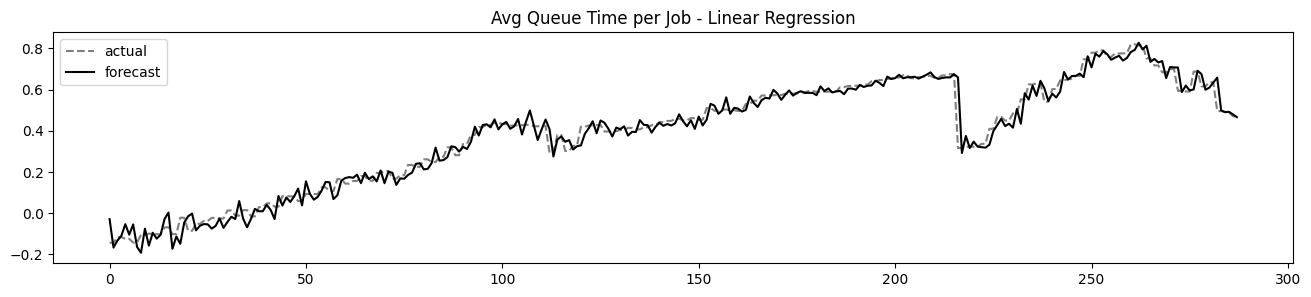

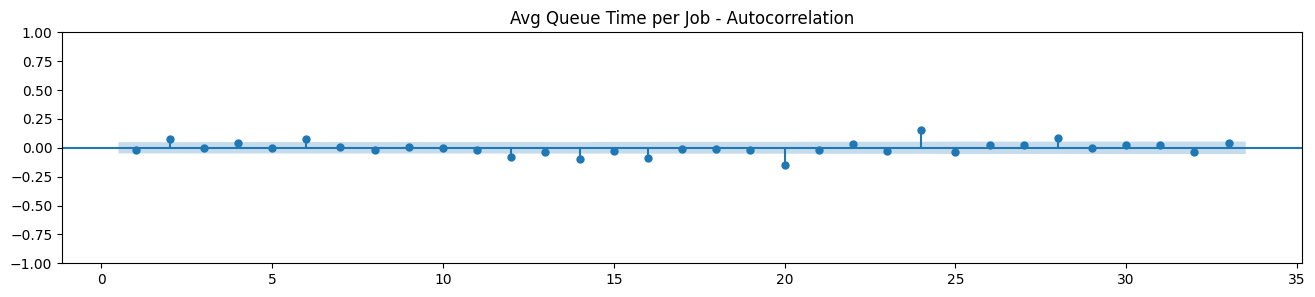

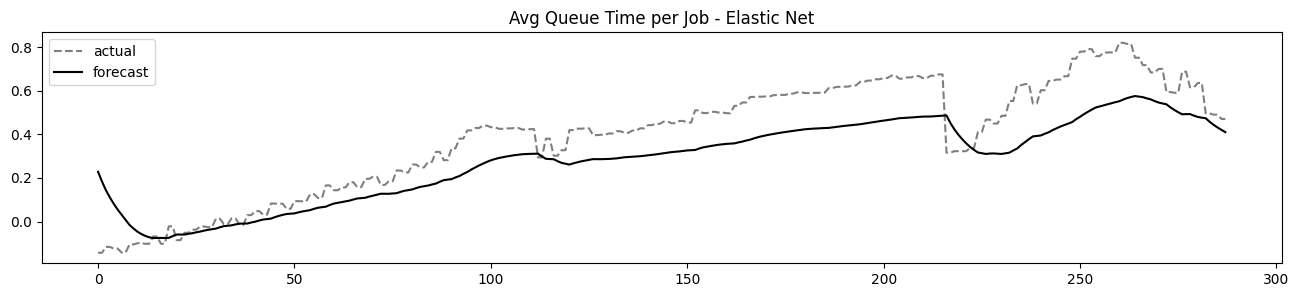

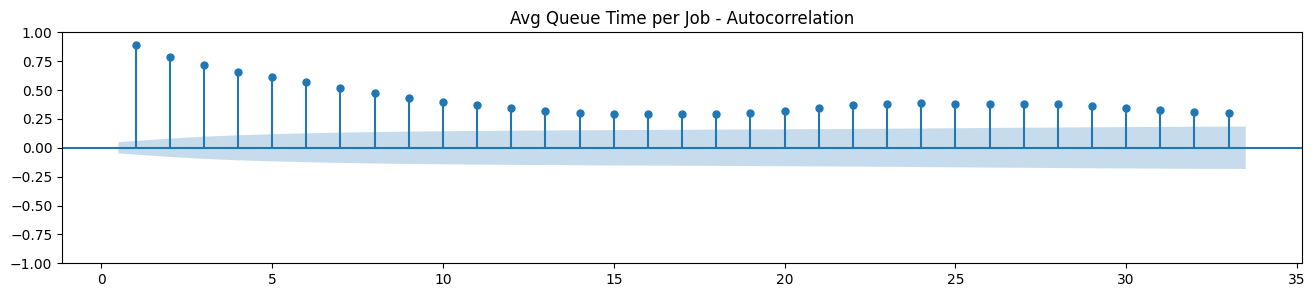

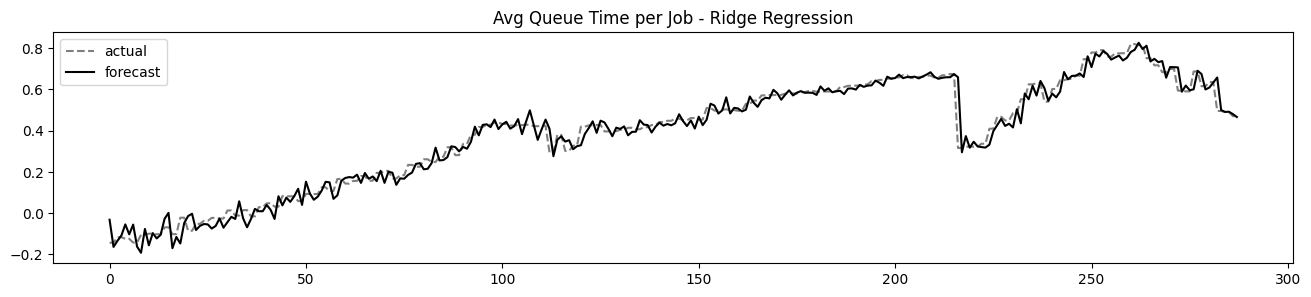

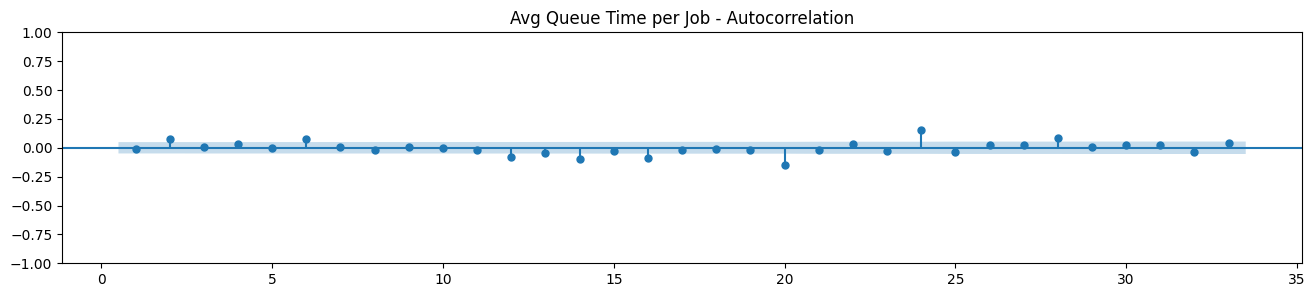

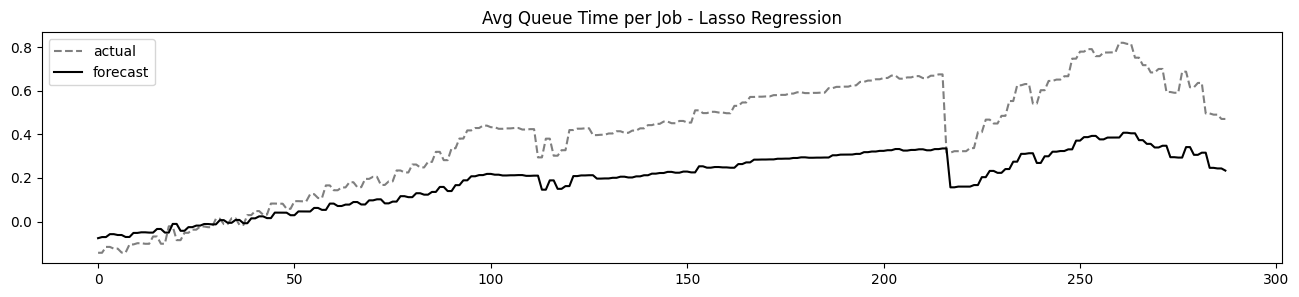

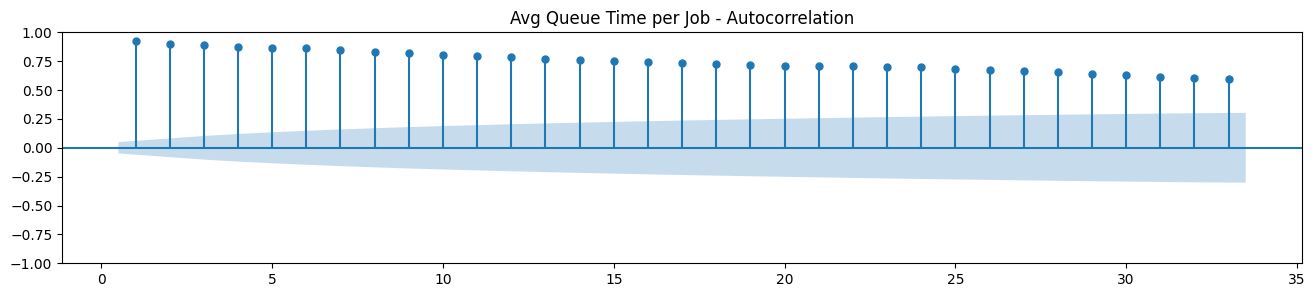

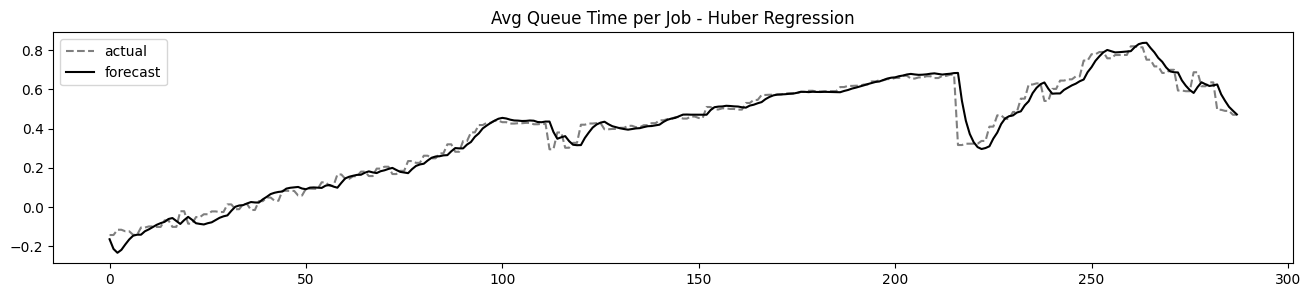

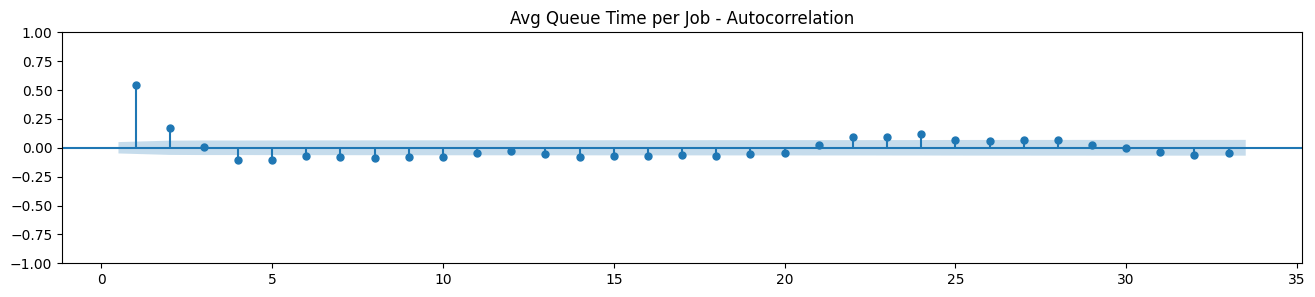

In [323]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
_range = range(a_day_period)
plot_results(cols, one_step_results, 'Avg Queue Time per Job', _range)